# Notebook de modelisation

In [13]:
!uv pip install scikit-learn numpy hdbscan

Using Python 3.11.6 environment at: c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 5 - Segmentez des clients d'un site e-commerce\.venv_p5
Audited 3 packages in 17ms


In [14]:
import pandas as pd
import numpy as np
from sklearn import cluster, metrics, mixture
from sklearn.datasets import make_blobs
import time
import hdbscan  # Pour HDBSCAN
from joblib import Parallel, delayed

# Import des dataframes RFM

In [15]:
rfm = pd.read_excel('RFM.xlsx')
rfm = rfm.drop(['customer_unique_id', 'Segment'], axis=1).dropna()
rfm.head()

,Unnamed: 0,R,F,M
0,0,160,1,141.90
1,1,163,1,27.19
2,2,585,1,86.22
3,3,369,1,43.62
4,4,336,1,196.89


In [16]:
rfmls  = pd.read_excel('RFMLS.xlsx')
rfmls = rfmls.drop(['customer_unique_id'], axis=1).dropna()
rfmls.head()

,Unnamed: 0,R,F,M,S,L
0,0,160,1,141.90,5,cajamar
1,1,163,1,27.19,4,osasco
2,2,585,1,86.22,3,sao jose
3,3,369,1,43.62,4,belem
4,4,336,1,196.89,5,sorocaba


# Benchmark des models

Les modèles de clustering dispo avec [sklearn](https://scikit-learn.org/stable/modules/clustering.html) et son tableau comparatif

## Benchmark RFM

In [17]:
# On prend 10% des données pour gagné du temps d'execution
rfm_sample = rfm.sample(frac=0.1, random_state=42)
print(rfm_sample.shape)

(9610, 4)


In [18]:
def evaluate_algorithm(name, algorithm, data):
    start_time = time.time()

    # Fit et prédire les labels
    labels = algorithm.fit_predict(data)
    elapsed_time = time.time() - start_time

    # Calcul des scores
    silhouette_score = metrics.silhouette_score(data, labels) if len(set(labels)) > 1 else None
    davies_bouldin_score = metrics.davies_bouldin_score(data, labels) if len(set(labels)) > 1 else None
    calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels) if len(set(labels)) > 1 else None

    return {
        "Algorithm": name,
        "Time (s)": elapsed_time,
        "Silhouette Score": silhouette_score,
        "Davies-Bouldin Score": davies_bouldin_score,
        "Calinski-Harabasz Score": calinski_harabasz_score
    }

In [19]:
# Liste des algorithmes à comparer
n_cluster_value = 6
min_sample_value = 100

model_list = {
    'kmeans': cluster.KMeans(n_clusters=n_cluster_value),
    'minibatchkmeans': cluster.MiniBatchKMeans(n_clusters=n_cluster_value),
    'hdbscan': hdbscan.HDBSCAN(min_cluster_size=min_sample_value),
    'gmm': mixture.GaussianMixture(n_components=n_cluster_value),
    'birch': cluster.Birch(n_clusters=n_cluster_value),
    'agglomerative': cluster.AgglomerativeClustering(n_clusters=n_cluster_value),
    'dbscan': cluster.DBSCAN(eps=0.5, min_samples=min_sample_value),
    'optics': cluster.OPTICS(min_samples=min_sample_value),
    'meanshift': cluster.MeanShift(),
}

In [20]:
results = []

# Exécution en parallèle avec joblib
results = Parallel(n_jobs=-1)(delayed(evaluate_algorithm)(name, algorithm, rfm_sample)for name, algorithm in model_list.items())

# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)

In [21]:
results_df.columns

Index(['Algorithm', 'Time (s)', 'Silhouette Score', 'Davies-Bouldin Score',
       'Calinski-Harabasz Score'],
      dtype='object')

In [22]:
# Silhouette Score : Plus il est élevé, mieux c'est
# Davies-Bouldin Score : Plus il est faible, mieux c'est 
# Calinski-Harabasz Score : Plus il est élevé, mieux c'est

results_df.sort_values(by=['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'], ascending=[False, True, False])

,Algorithm,Time (s),Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
1,minibatchkmeans,0.154018,0.557312,0.498288,67687.212522
0,kmeans,0.155886,0.556595,0.499247,67749.960298
4,birch,7.225314,0.542144,0.497420,63840.120108
5,agglomerative,10.794648,0.542144,0.497420,63840.120108
8,meanshift,137.276659,0.538532,0.503872,27050.627977
2,hdbscan,0.564836,0.404888,2.035186,8817.566000
7,optics,21.915144,0.232666,0.498577,1128.692954
3,gmm,0.421330,0.060213,62.857433,3174.979797
6,dbscan,0.114416,NaN,NaN,NaN


## Find the best number of cluster

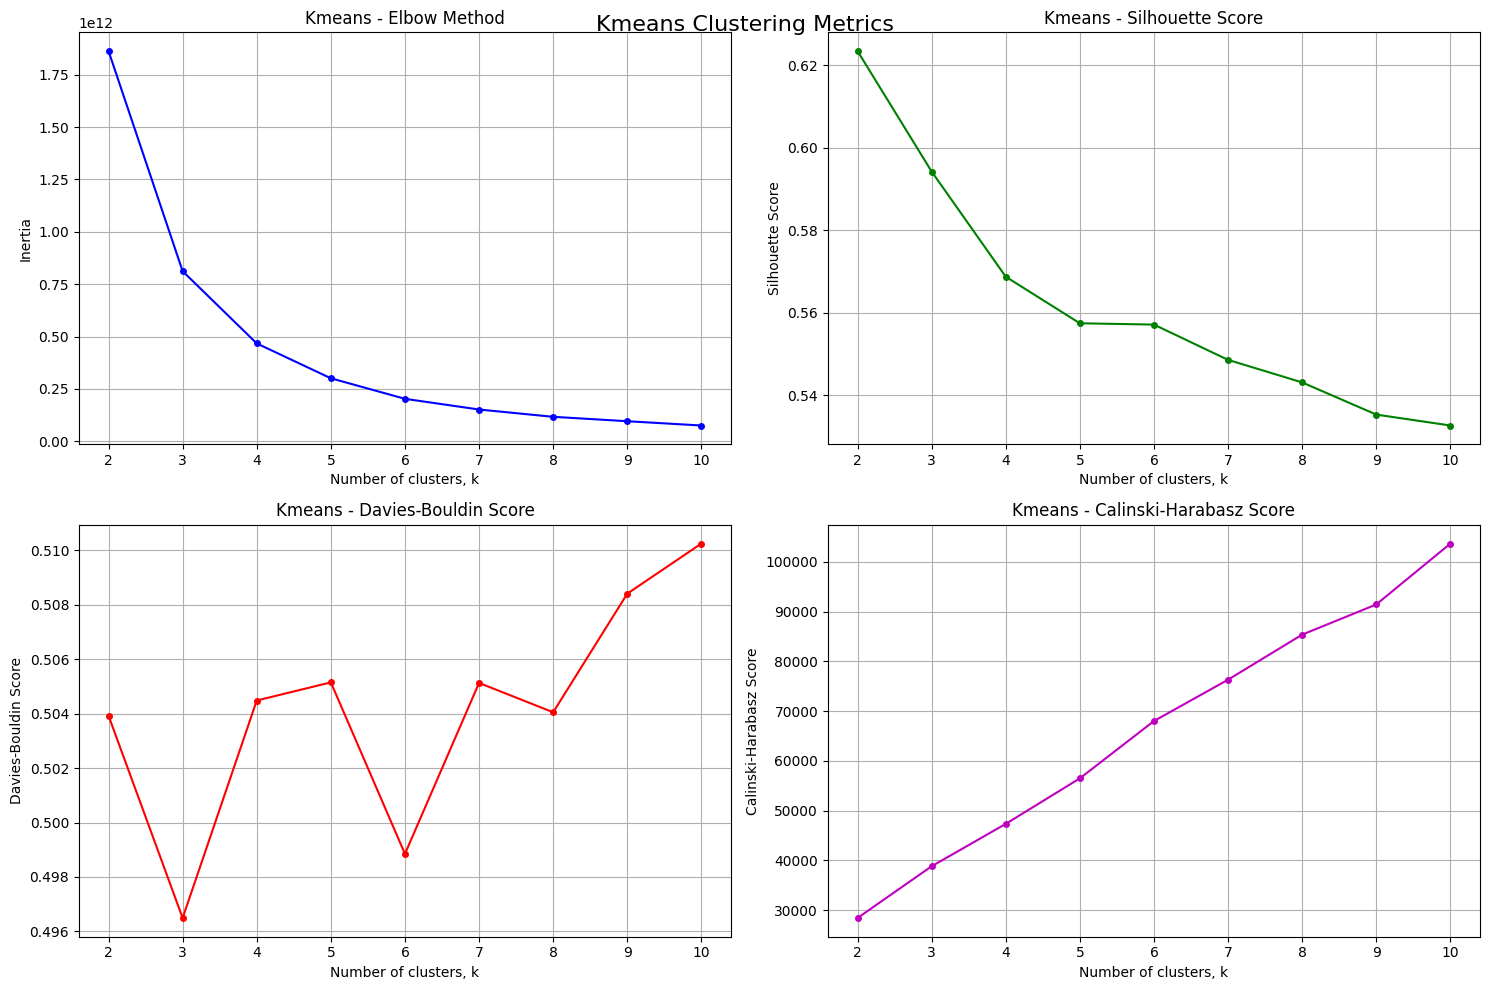

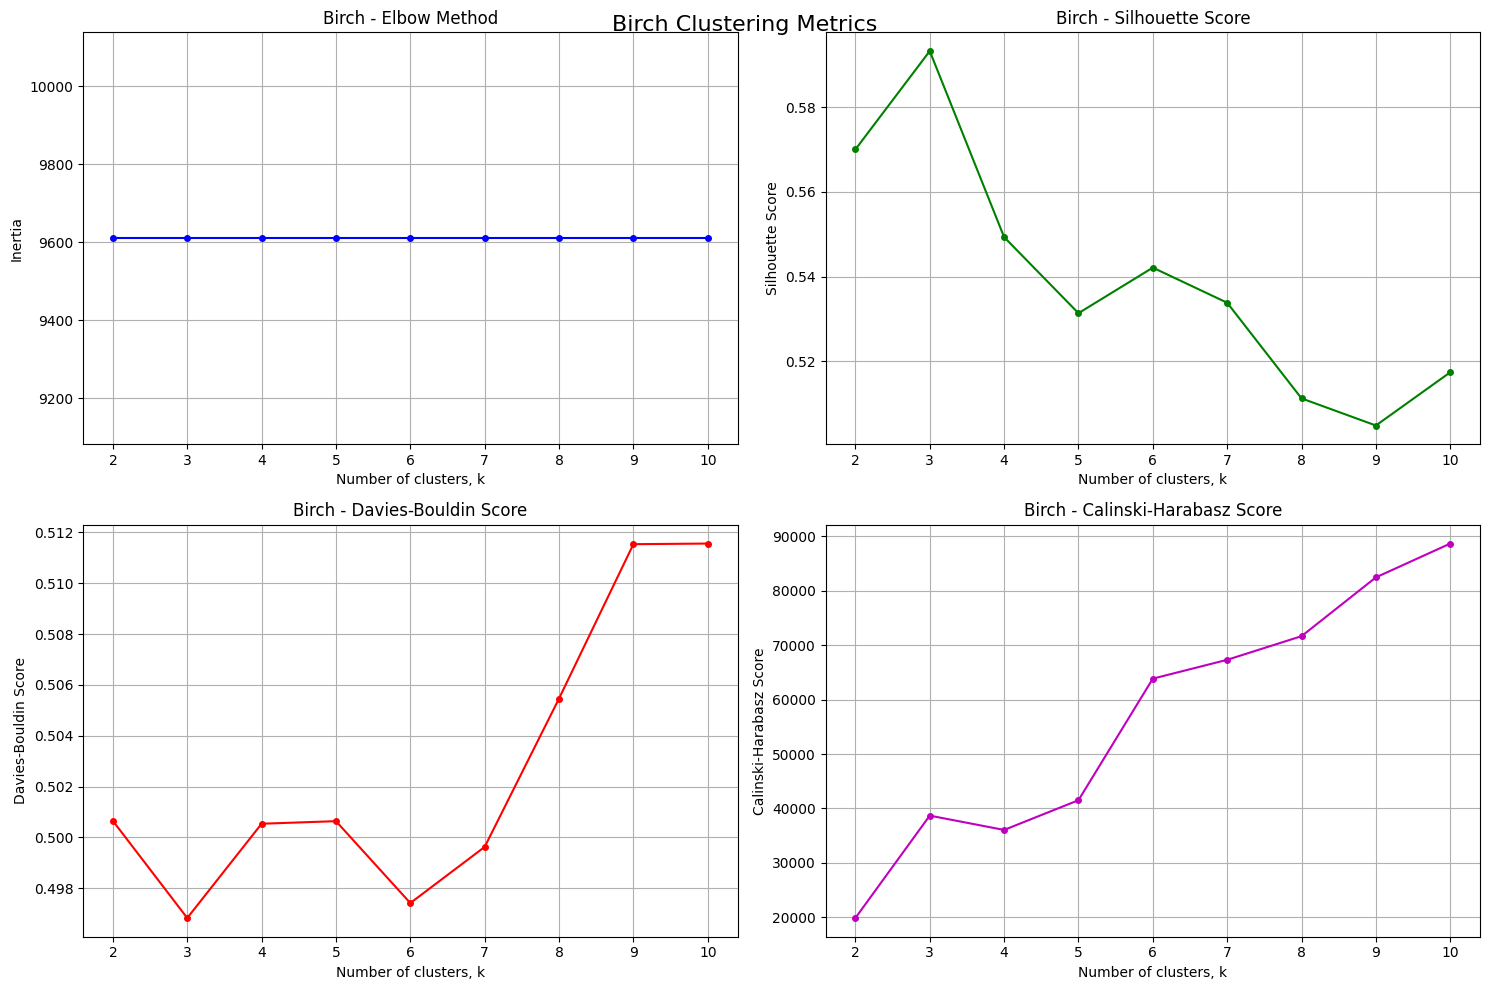

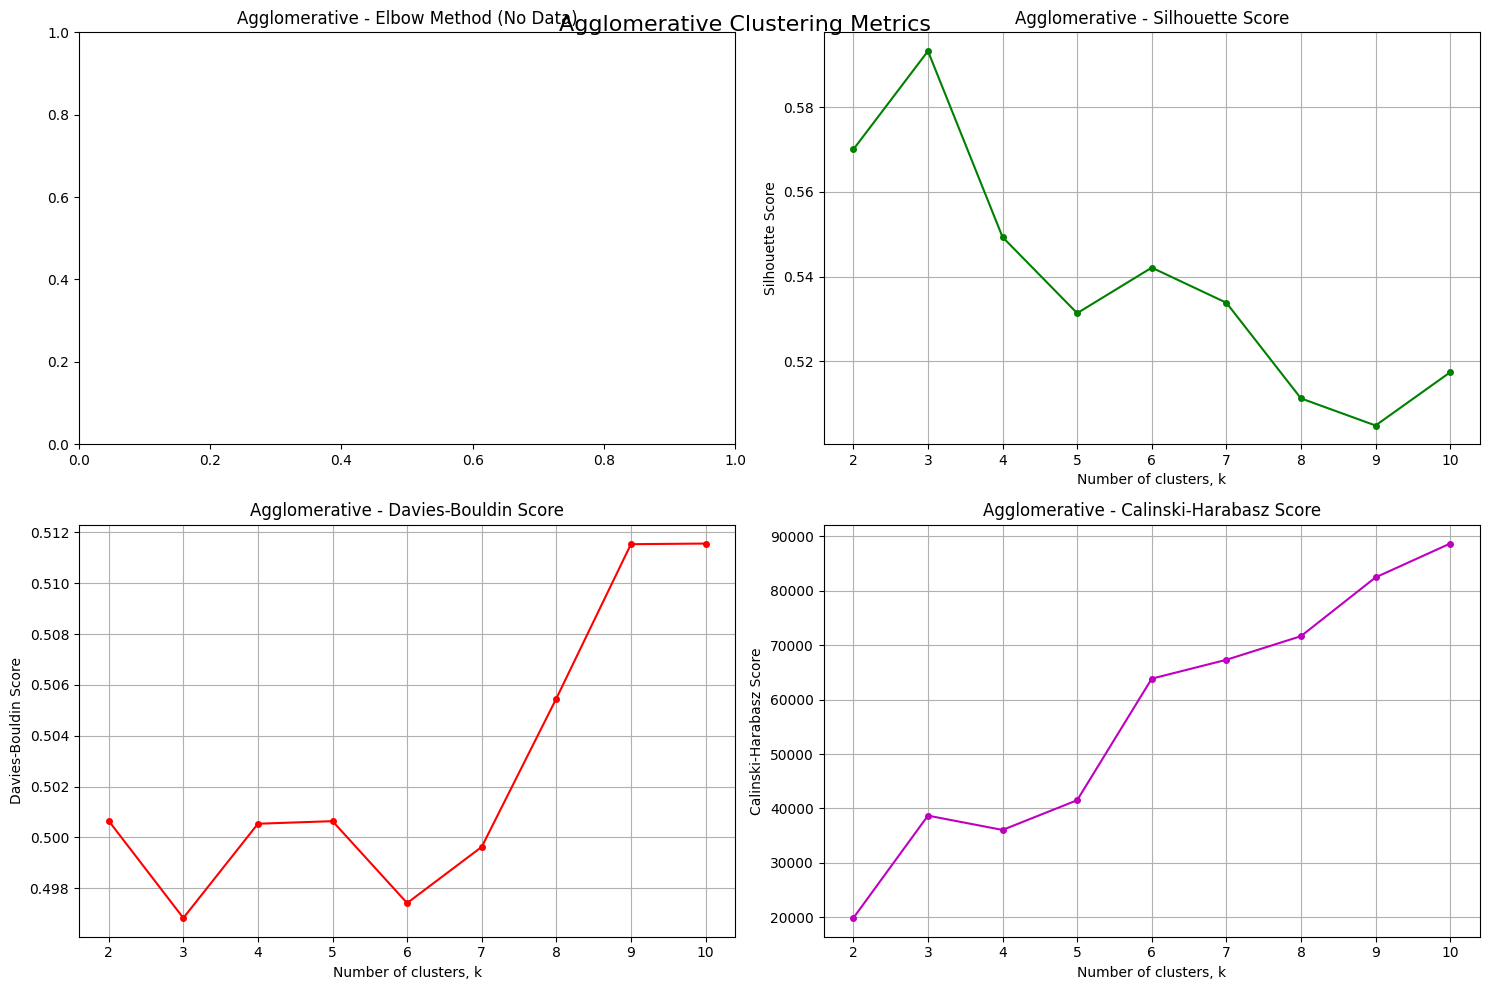

In [27]:
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def plot_metrics_for_each_model(data, max_k=10):
    metrics = {
        'kmeans': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'birch': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'agglomerative': {'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
    }

    k_values = range(2, max_k + 1)

    for k in k_values:
        # KMeans
        kmeans = cluster.KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        metrics['kmeans']['inertia'].append(kmeans.inertia_)
        if len(set(labels)) > 1:
            metrics['kmeans']['silhouette'].append(silhouette_score(data, labels))
            metrics['kmeans']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['kmeans']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Birch
        birch = cluster.Birch(n_clusters=k)
        labels = birch.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['birch']['inertia'].append(birch.subcluster_centers_.shape[0])  # Approximation of inertia
            metrics['birch']['silhouette'].append(silhouette_score(data, labels))
            metrics['birch']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['birch']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Agglomerative Clustering
        agg = cluster.AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['agglomerative']['silhouette'].append(silhouette_score(data, labels))
            metrics['agglomerative']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['agglomerative']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

    # Tracé des métriques pour chaque modèle
    models = ['kmeans', 'birch', 'agglomerative']
    for model in models:
        plt.figure(figsize=(15, 10))

        # Elbow Method
        plt.subplot(2, 2, 1)
        if 'inertia' in metrics[model] and len(metrics[model]['inertia']) > 0:
            plt.plot(k_values, metrics[model]['inertia'], 'bo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Inertia')
            plt.title(f'{model.capitalize()} - Elbow Method')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Elbow Method (No Data)')

        # Silhouette Score
        plt.subplot(2, 2, 2)
        if len(metrics[model]['silhouette']) > 0:
            plt.plot(k_values, metrics[model]['silhouette'], 'go-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Silhouette Score')
            plt.title(f'{model.capitalize()} - Silhouette Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Silhouette Score (No Data)')

        # Davies-Bouldin Score
        plt.subplot(2, 2, 3)
        if len(metrics[model]['davies_bouldin']) > 0:
            plt.plot(k_values, metrics[model]['davies_bouldin'], 'ro-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Davies-Bouldin Score')
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score (No Data)')

        # Calinski-Harabasz Score
        plt.subplot(2, 2, 4)
        if len(metrics[model]['calinski_harabasz']) > 0:
            plt.plot(k_values, metrics[model]['calinski_harabasz'], 'mo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Calinski-Harabasz Score')
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score (No Data)')

        plt.tight_layout()
        plt.suptitle(f'{model.capitalize()} Clustering Metrics', fontsize=16)
        plt.show()

# Exemple d'utilisation avec des données fictives
# data = ... (votre jeu de données)
plot_metrics_for_each_model(rfm_sample)


Correspondance avec les sagments defini dans l'EDA
segment_order = ['Champions', 'Loyaux', 'Loyalistes potentiels', 'À réactiver', 'À risque', 'Perdus']

3 Correspond au 3 persona les plus presents et 6 correspond a tous les personas !

## Classification des clusters

### Vue 2D

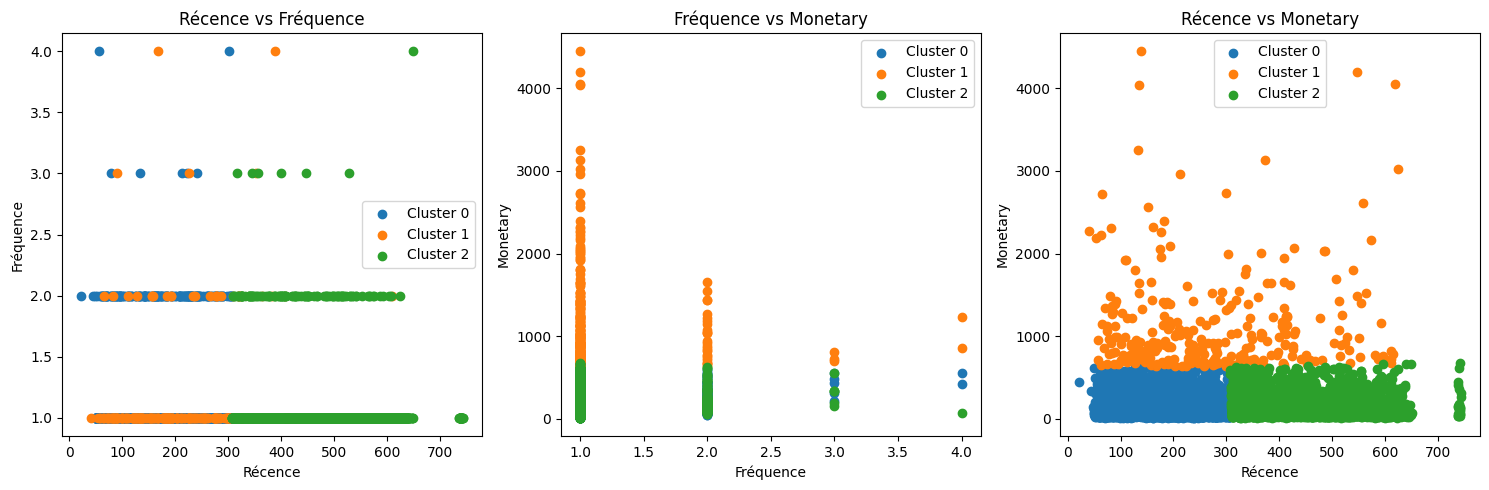

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supposons que 'rfm_sample' est votre rfm_sampleFrame RFM
# rfm_sample = pd.rfm_sampleFrame(...)

# Appliquer KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_sample['Cluster'] = kmeans.fit_predict(rfm_sample[['R', 'F', 'M']])

# Analyser les centres des clusters
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['R', 'F', 'M'])
# print("Centres des clusters :")
# print(centers)

# Calculer les statistiques descriptives pour chaque cluster
cluster_stats = rfm_sample.groupby('Cluster')[['R', 'F', 'M']].agg(['mean', 'median', 'std'])
# print("Statistiques descriptives des clusters :")
# print(cluster_stats)

# Visualiser les clusters
plt.figure(figsize=(15, 5))

# Graphique Récence vs Fréquence
plt.subplot(1, 3, 1)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['R'], rfm_sample[rfm_sample['Cluster'] == cluster]['F'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Fréquence')
plt.title('Récence vs Fréquence')
plt.legend()

# Graphique Fréquence vs Monetary
plt.subplot(1, 3, 2)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['F'], rfm_sample[rfm_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Fréquence')
plt.ylabel('Monetary')
plt.title('Fréquence vs Monetary')
plt.legend()

# Graphique Récence vs Monetary
plt.subplot(1, 3, 3)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['R'], rfm_sample[rfm_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Monetary')
plt.title('Récence vs Monetary')
plt.legend()

plt.tight_layout()
plt.show()


### Vue 3D

In [35]:
import plotly.express as px
import pandas as pd

# Supposons que 'data' est votre DataFrame RFM avec une colonne 'Cluster'
# data = pd.DataFrame(...)

# Créer un graphique 3D avec Plotly
fig = px.scatter_3d(rfm_sample, x='R', y='F', z='M', color='Cluster',
                    labels={'R': 'Récence', 'F': 'Fréquence', 'M': 'Monetary', 'Cluster': 'Cluster'},
                    title='Clustering RFM en 3D')

# Afficher le graphique
fig.show()
